**Tuning**: Balanced with 3-4 parameters, 5-fold CV, ~6–8 min runtime

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

In [2]:
repo_root = Path.cwd().parent  # assuming notebook is under /notebooks
data_path = repo_root / "data" / "clean" / "student_clean_classification_noG1G2.csv"
assert data_path.exists(), f"Missing: {data_path}"

df = pd.read_csv(data_path)
TARGET = "performance_level"

LEAK = {"G1", "G2", "G3"} #just in case
features = [c for c in df.columns if c not in LEAK | {TARGET}]
X = df[features].copy()
y = df[TARGET].copy()

print("Shapes:", X.shape, y.shape)
y.value_counts(normalize=True).sort_index()

Shapes: (1044, 40) (1044,)


performance_level
High      0.195402
Low       0.220307
Medium    0.584291
Name: proportion, dtype: float64

In [3]:
X.isna().sum().sum(), y.isna().sum() # Quick NA check (should be 0s)

(0, 0)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Train/Test:", X_train.shape, X_test.shape)

Train/Test: (835, 40) (209, 40)


In [5]:
pipe_logreg = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", multi_class="ovr", random_state=42))])

pipe_rf = Pipeline([
    ("model", RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1))])

pipe_svm = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("model", SVC(kernel="rbf", class_weight="balanced", probability=False, random_state=42))])


grid_logreg = {
    "model__C": [0.25, 0.5, 1.0, 2.0],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs", "liblinear"], 
}

grid_rf = {
    "model__n_estimators": [200, 300, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 4, 6],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None],
}

grid_svm = {
    "model__C": [0.5, 1.0, 2.0, 4.0],
    "model__gamma": ["scale", 0.1, 0.01],
}



[Logistic Regression] best params: {'model__C': 0.25, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
[Logistic Regression] CV best macro-F1 (mean): 0.504
[Logistic Regression] Test: acc=0.589 | macro-F1=0.536

              precision    recall  f1-score   support

        High      0.350     0.341     0.346        41
         Low      0.583     0.609     0.596        46
      Medium      0.669     0.664     0.667       122

    accuracy                          0.589       209
   macro avg      0.534     0.538     0.536       209
weighted avg      0.588     0.589     0.588       209



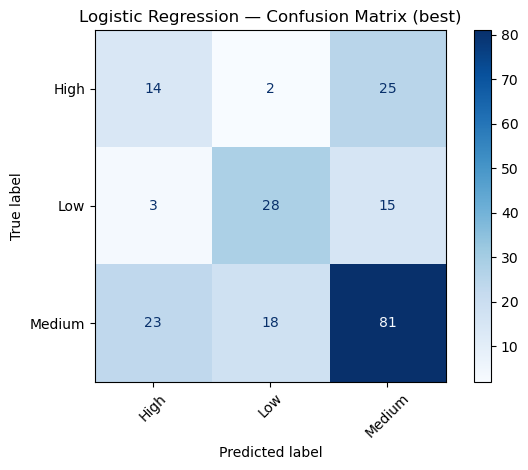


[Random Forest] best params: {'model__max_depth': None, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 200}
[Random Forest] CV best macro-F1 (mean): 0.541
[Random Forest] Test: acc=0.670 | macro-F1=0.623

              precision    recall  f1-score   support

        High      0.576     0.463     0.514        41
         Low      0.617     0.630     0.624        46
      Medium      0.713     0.754     0.733       122

    accuracy                          0.670       209
   macro avg      0.635     0.616     0.623       209
weighted avg      0.665     0.670     0.666       209



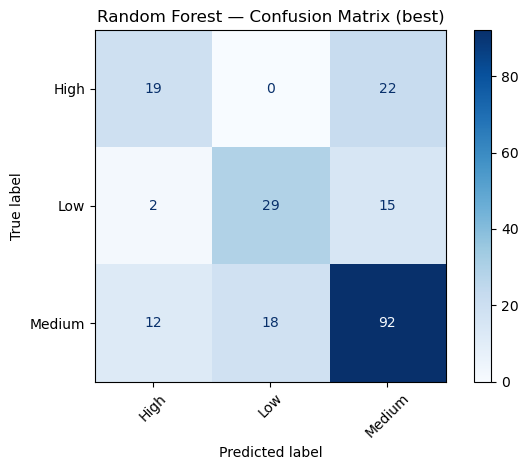


[SVM (RBF)] best params: {'model__C': 4.0, 'model__gamma': 0.01}
[SVM (RBF)] CV best macro-F1 (mean): 0.532
[SVM (RBF)] Test: acc=0.536 | macro-F1=0.533

              precision    recall  f1-score   support

        High      0.431     0.683     0.528        41
         Low      0.459     0.609     0.523        46
      Medium      0.675     0.459     0.546       122

    accuracy                          0.536       209
   macro avg      0.521     0.584     0.533       209
weighted avg      0.579     0.536     0.538       209



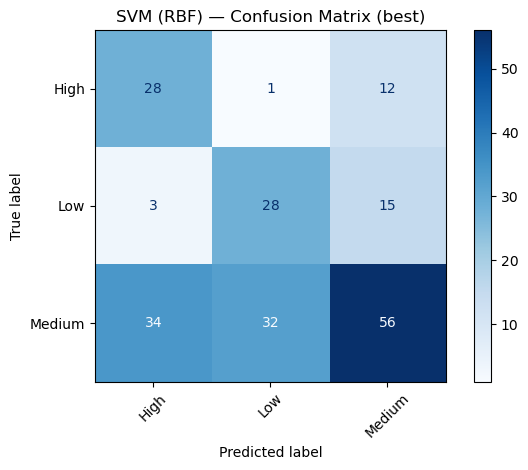

In [6]:
scoring = {"acc": "accuracy", "f1m": "f1_macro"}

def run_grid(name, pipe, grid):
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        cv=cv5,
        scoring=scoring,
        refit="f1m",             
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_train, y_train)
    y_pred = gs.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    print(f"\n[{name}] best params:", gs.best_params_)
    print(f"[{name}] CV best macro-F1 (mean): {gs.best_score_:.3f}")
    print(f"[{name}] Test: acc={acc:.3f} | macro-F1={f1m:.3f}\n")
    print(classification_report(y_test, y_pred, digits=3))
    disp = ConfusionMatrixDisplay.from_estimator(gs.best_estimator_, X_test, y_test, cmap="Blues", xticks_rotation=45)
    plt.title(f"{name} — Confusion Matrix (best)")
    plt.tight_layout()
    plt.show()
    return gs, acc, f1m

gs_logreg, acc_lr, f1_lr = run_grid("Logistic Regression", pipe_logreg, grid_logreg)
gs_rf, acc_rf, f1_rf     = run_grid("Random Forest",       pipe_rf,    grid_rf)
gs_svm, acc_svm, f1_svm = run_grid("SVM (RBF)",           pipe_svm,   grid_svm)

In [7]:
cm_out = repo_root / "data" / "model_outputs"

def save_cm(best_estimator, name):
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, y_test, cmap="Blues", ax=ax, xticks_rotation=45)
    ax.set_title(f"{name} — Confusion Matrix (tuned)")
    fig.tight_layout()
    fig.savefig(cm_out / f"confusion_matrix_{name.lower().replace(' ', '_')}_tuned.png", dpi=150)
    plt.close(fig)

save_cm(gs_logreg.best_estimator_, "logistic_regression")
save_cm(gs_rf.best_estimator_,     "random_forest")
save_cm(gs_svm.best_estimator_,    "svm_rbf")
print("Saved tuned confusion matrices.")


Saved tuned confusion matrices.


In [8]:
out_dir = repo_root / "data" / "model_outputs"
out_dir.mkdir(parents=True, exist_ok=True)

metrics = pd.DataFrame([
    {"Model": "Logistic Regression (tuned)", "Accuracy": acc_lr, "Macro-F1": f1_lr, "BestParams": gs_logreg.best_params_},
    {"Model": "Random Forest (tuned)",       "Accuracy": acc_rf, "Macro-F1": f1_rf, "BestParams": gs_rf.best_params_},
    {"Model": "SVM RBF (tuned)",             "Accuracy": acc_svm,"Macro-F1": f1_svm,"BestParams": gs_svm.best_params_},
])
metrics_path = out_dir / "final_model_metrics.csv"
metrics.to_csv(metrics_path, index=False)
print("Saved:", metrics_path.as_posix())
metrics

if hasattr(gs_rf.best_estimator_.named_steps["model"], "feature_importances_"):
    importances = gs_rf.best_estimator_.named_steps["model"].feature_importances_
    feat_imp = pd.DataFrame({"feature": X.columns, "importance": importances}).sort_values("importance", ascending=False)
    fi_path = out_dir / "rf_feature_importances_tuned.csv"
    feat_imp.to_csv(fi_path, index=False)
    print("Saved:", fi_path.as_posix())

Saved: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/final_model_metrics.csv
Saved: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/rf_feature_importances_tuned.csv


In [9]:
try:
    baseline = pd.read_csv(out_dir / "model_metrics_summary.csv")
    baseline["Stage"] = "Baseline"
except Exception:
    baseline = pd.DataFrame(columns=["Model","Accuracy","Macro-F1","Stage"])

tuned = metrics.copy()
tuned["Stage"] = "Tuned"

compare = pd.concat([baseline, tuned], ignore_index=True)
compare_path = out_dir / "model_metrics_compare_baseline_tuned.csv"
compare.to_csv(compare_path, index=False)
print("Saved:", compare_path.as_posix())
compare

Saved: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/model_metrics_compare_baseline_tuned.csv


,Model,Accuracy,Macro-F1,CM_path,Stage,BestParams
0,Logistic Regression (no leak),0.507177,0.504230,/Users/gisselletosta/Final-Project-Team-4-AAI5...,Baseline,NaN
1,Random Forest,0.636364,0.502255,/Users/gisselletosta/Final-Project-Team-4-AAI5...,Baseline,NaN
2,SVM (RBF kernel),0.473684,0.479032,/Users/gisselletosta/Final-Project-Team-4-AAI5...,Baseline,NaN
3,Logistic Regression (tuned),0.588517,0.536030,NaN,Tuned,"{'model__C': 0.25, 'model__penalty': 'l2', 'mo..."
4,Random Forest (tuned),0.669856,0.623412,NaN,Tuned,"{'model__max_depth': None, 'model__max_feature..."
5,SVM RBF (tuned),0.535885,0.532669,NaN,Tuned,"{'model__C': 4.0, 'model__gamma': 0.01}"
